# IT3212 - Assignment 2

## Setup

In [57]:
import pandas as pd

filepath = './data/disaster-tweets.csv'
df = pd.read_csv(filepath, encoding='ISO-8859-1')

## Feature extraction before preprocessing

Some extracted features of interest must be done before preprocessing any data. These features are:

- `hashtag_count`: number of hashtags in the tweet
- `mention_count`: number of mentions in the tweet
- `has_url`: whether the tweet contains a URL

In [58]:
# Extract the number of hashtags
df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# Extract the number of mentions
df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

# Extract the `has_url` feature
df['has_url'] = df['text'].apply(lambda x: 1 if 'http' in str(x) else 0)

# Write the updated dataframe to a CSV file
df.to_csv('./results/00-with-extracted-features.csv', index=False)
display(df.head())


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid,hashtag_count,mention_count,has_url
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN,0,0,0
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN,1,0,0
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN,1,0,0
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN,0,0,0
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN,0,0,0


## 1. Implement the preprocessing

### 1.1 Removing data

In [59]:
# Only keep the columns we need
original_features = [
  '_unit_id', '_golden', '_unit_state', '_trusted_judgments',
  '_last_judgment_at', 'choose_one', 'choose_one:confidence',
  'choose_one_gold', 'keyword', 'location', 'text', 'tweetid', 'userid'
  ]
features_to_keep = ['choose_one', 'choose_one:confidence', 'keyword', 'location', 'text']
df = df[features_to_keep]
display(df.head())

# Remove rows with a confidence score less than 1.0
confidence_threshold = 1.0
df = df[df['choose_one:confidence'] >= confidence_threshold]

# Write the updated dataframe to a new CSV file
df.to_csv('./results/01-remove-features.csv', index=False)

,choose_one,choose_one:confidence,keyword,location,text
0,Relevant,1.0000,NaN,NaN,Just happened a terrible car crash
1,Relevant,1.0000,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
2,Relevant,1.0000,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,Relevant,0.9603,NaN,NaN,"there is a forest fire at spot pond, geese are..."
4,Relevant,1.0000,NaN,NaN,Forest fire near La Ronge Sask. Canada


### 1.2 Text processing

,choose_one,choose_one:confidence,keyword,location,text
0,Relevant,1.0,,NaN,Just happened a terrible car crash
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s..."
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...


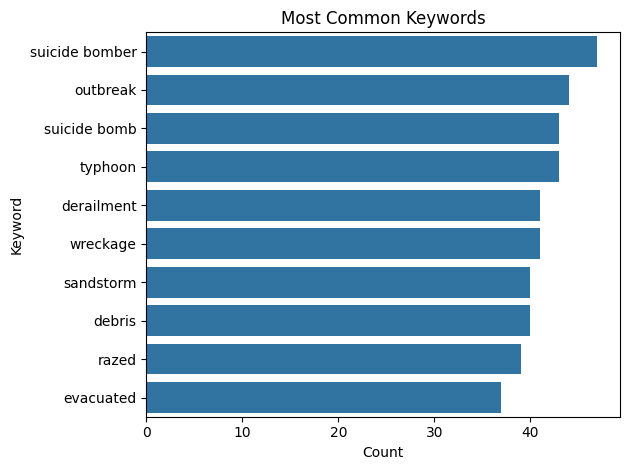

In [60]:
from urllib.parse import unquote

# Clean `keyword` column.
def clean_keyword(keyword: str):
    return unquote(keyword) if pd.notnull(keyword) else ''

df['keyword'] = df['keyword'].apply(clean_keyword).apply(str.lower)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/02-clean-keywords.csv', index=False)
display(df.head())

# Plot the most common keywords
import matplotlib.pyplot as plt
import seaborn as sns

defined_keywords = df[df['keyword'] != '']['keyword']

plt.figure()
sns.countplot(y=defined_keywords, order=defined_keywords.value_counts().iloc[:10].index)
plt.title('Most Common Keywords')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.tight_layout()
plt.savefig('./results/03-keywords.png')
plt.show()


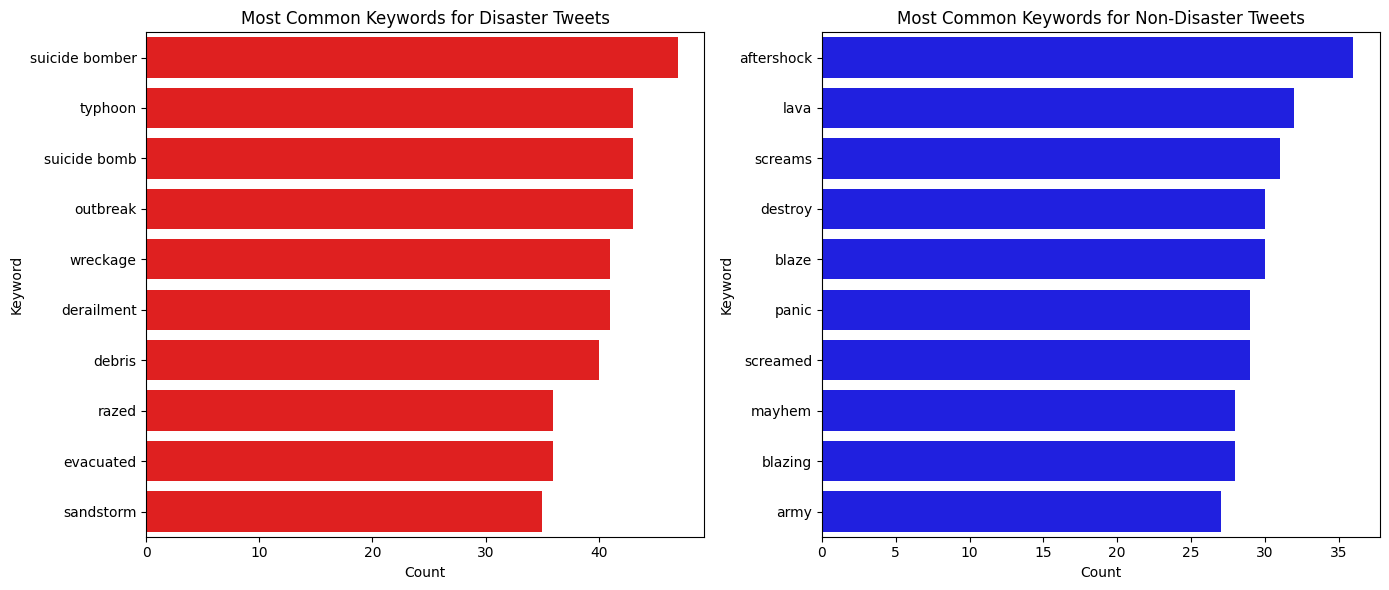

In [61]:
# Compare keywords for disaster tweets and non-disaster tweets
disaster_keywords = df[df['choose_one'] == 'Relevant']['keyword']
non_disaster_keywords = df[df['choose_one'] == 'Not Relevant']['keyword']

# Create a figure object and define the grid
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plotting
sns.countplot(y=disaster_keywords, ax=ax[0], order=disaster_keywords.value_counts().iloc[:10].index, color='red')
sns.countplot(y=non_disaster_keywords, ax=ax[1], order=non_disaster_keywords.value_counts().iloc[:10].index, color='blue')

# Titles and labels
ax[0].set_title('Most Common Keywords for Disaster Tweets')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Keyword')

ax[1].set_title('Most Common Keywords for Non-Disaster Tweets')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Keyword')

# Adjust layout
plt.tight_layout()
plt.savefig('./results/keywords_comparison.png')
plt.show()


In the plot above, we can see that no top 10 shared keywords between disaster-related tweets and non-disaster-related tweets.

In [62]:
# Remove links from the `text` column
import string
import re


def clean_text(text: str):
  text = re.sub(r'https?://\S+', '', text)  # Remove link
  text = re.sub(r'\n', ' ', text)  # Remove line breaks
  # Remove leading, trailing, and extra spaces
  text = re.sub('\s+', ' ', text).strip()
  return text


df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

# Remove punctuation from the `text` column
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.translate(
    str.maketrans('', '', string.punctuation)))

# Write the updated dataframe to a new CSV file
df.to_csv('./results/03-clean-text.csv', index=False)
display(df.head())


,choose_one,choose_one:confidence,keyword,location,text,cleaned_text
0,Relevant,1.0,,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...


In [63]:
# Remove English stopwords
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Clean `text` column.
def clean_text(text: str):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


df['cleaned_text'] = df['cleaned_text'].apply(clean_text)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/04-without-stopwords.csv', index=False)
display(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Haakon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,choose_one,choose_one:confidence,keyword,location,text,cleaned_text
0,Relevant,1.0,,NaN,Just happened a terrible car crash,happened terrible car crash
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...


In [64]:
# Lemmatizing the `text` column
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Clean `text` column.
def clean_text(text: str):
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text


df['cleaned_text'] = df['cleaned_text'].apply(clean_text)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/05-lemmatized.csv', index=False)
display(df.head())


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Haakon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,choose_one,choose_one:confidence,keyword,location,text,cleaned_text
0,Relevant,1.0,,NaN,Just happened a terrible car crash,happened terrible car crash
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...


In [65]:
import contractions

# Remove contractions
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: contractions.fix(x))

# Write the updated dataframe to a new CSV file
df.to_csv('./results/07-without-contractions.csv', index=False)
display(df.head(50))


,choose_one,choose_one:confidence,keyword,location,text,cleaned_text
0,Relevant,1.0,,NaN,Just happened a terrible car crash,happened terrible car crash
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive you
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
6,Relevant,1.0,,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfire evacuation order...
7,Relevant,1.0,,NaN,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...
8,Relevant,1.0,,NaN,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy 20 closed dire...
10,Relevant,1.0,,NaN,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain because flash floodi...
11,Relevant,1.0,,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


In [66]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

# Tokenize the `text` column
def tokenize_text(text: str):
    return tokenizer.tokenize(text)

df['tokens'] = df['cleaned_text'].apply(tokenize_text)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/07-tokens.csv', index=False)
display(df.head())

,choose_one,choose_one:confidence,keyword,location,text,cleaned_text,tokens
0,Relevant,1.0,,NaN,Just happened a terrible car crash,happened terrible car crash,"[happened, terrible, car, crash]"
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive you,"[deed, reason, earthquake, may, allah, forgive..."
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,"[heard, earthquake, different, city, stay, saf..."
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,"[resident, asked, shelter, place, notified, of..."


### 1.3 Handling categorical data

,choose_one,choose_one:confidence,keyword,location,text,cleaned_text,tokens,target
0,Relevant,1.0,,NaN,Just happened a terrible car crash,happened terrible car crash,"[happened, terrible, car, crash]",1
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive you,"[deed, reason, earthquake, may, allah, forgive...",1
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,"[heard, earthquake, different, city, stay, saf...",1
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",1
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,"[resident, asked, shelter, place, notified, of...",1


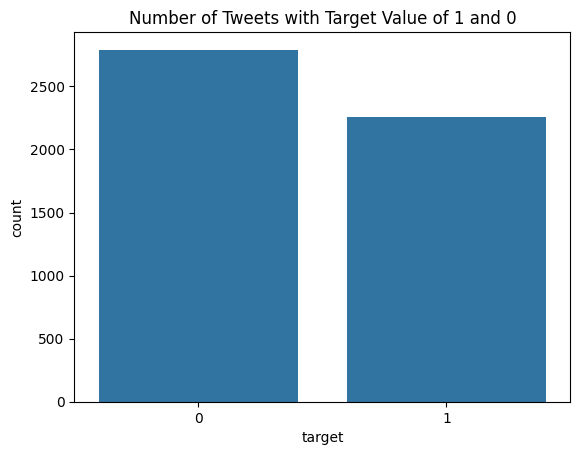

In [67]:
# Remove rows with `choose_one` value of `Can't Decide`
df = df[df['choose_one'] != "Can't Decide"]

# Replace the `choose_one` column with a new column called `target`, where `Relevant` is `1` and `Not Relevant` is `0`
df['target'] = df['choose_one'].apply(lambda x: 1 if x == 'Relevant' else 0)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/07-with-target-variable.csv', index=False)
display(df.head())

# Plot the amount of tweets with target value of `1` and `0`
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df)
plt.title('Number of Tweets with Target Value of 1 and 0')
plt.show()

### 1.4 Duplicated data

In [68]:
print("Number of rows before removing duplicates", df.shape[0])

# Remove duplicated rows with respect to the `text` column
df = df.drop_duplicates(subset=['text'])

print("Number of rows after removing duplicates", df.shape[0])

# Write the updated dataframe to a new CSV file
df.to_csv('./results/08-without-duplicates-in-text.csv', index=False)
display(df.head())

Number of rows before removing duplicates 5046
Number of rows after removing duplicates 4979


,choose_one,choose_one:confidence,keyword,location,text,cleaned_text,tokens,target
0,Relevant,1.0,,NaN,Just happened a terrible car crash,happened terrible car crash,"[happened, terrible, car, crash]",1
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive you,"[deed, reason, earthquake, may, allah, forgive...",1
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,"[heard, earthquake, different, city, stay, saf...",1
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",1
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,"[resident, asked, shelter, place, notified, of...",1


## 2. Extracting features

In [69]:
# Create new column for text length
df['text_length'] = df['cleaned_text'].apply(len)

# Write the updated dataframe to a new CSV file
df.to_csv('./results/09-with-text-length.csv', index=False)
display(df.head())

,choose_one,choose_one:confidence,keyword,location,text,cleaned_text,tokens,target,text_length
0,Relevant,1.0,,NaN,Just happened a terrible car crash,happened terrible car crash,"[happened, terrible, car, crash]",1,27
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive you,"[deed, reason, earthquake, may, allah, forgive...",1,44
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,"[heard, earthquake, different, city, stay, saf...",1,50
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",1,37
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,"[resident, asked, shelter, place, notified, of...",1,85


In [70]:
from textblob import TextBlob

def get_polarity(text: str):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text: str):
    return TextBlob(text).sentiment.subjectivity

# Apply functions to determine polarity and subjectivity
df['polarity'] = df['cleaned_text'].apply(get_polarity)
df['subjectivity'] = df['cleaned_text'].apply(get_subjectivity)

# Displaying the DataFrame
display(df.head())


,choose_one,choose_one:confidence,keyword,location,text,cleaned_text,tokens,target,text_length,polarity,subjectivity
0,Relevant,1.0,,NaN,Just happened a terrible car crash,happened terrible car crash,"[happened, terrible, car, crash]",1,27,-1.00,1.00
1,Relevant,1.0,,NaN,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive you,"[deed, reason, earthquake, may, allah, forgive...",1,44,0.00,0.00
2,Relevant,1.0,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,"[heard, earthquake, different, city, stay, saf...",1,50,0.25,0.55
4,Relevant,1.0,,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",1,37,0.10,0.40
5,Relevant,1.0,,NaN,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...,"[resident, asked, shelter, place, notified, of...",1,85,-0.10,0.40


## Sentiment analysis


In [71]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        return "Positive"
    elif sentiment_scores['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['cleaned_text'].apply(analyze_sentiment_vader)

df.sentiment.head()

0    Negative
1    Positive
2    Positive
4    Negative
5     Neutral
Name: sentiment, dtype: object

## Checking if sentiment and choose_one is correlated


In [72]:
from scipy import stats
disaster_group = df[df['choose_one'] == "Disaster"]
not_disaster_group = df[df['choose_one'] == "Not Disaster"]

t_statistic, p_value = stats.ttest_ind(disaster_group['sentiment'], not_disaster_group['sentiment'], equal_var=False)

if p_value < 0.05:
    print("There is a significant difference in sentiment between disaster and not disaster tweets.")
else:
    print("There is no significant difference in sentiment between disaster and not disaster tweets.")

There is no significant difference in sentiment between disaster and not disaster tweets.


## Create ngrams

In [73]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize


def create_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return n_grams


df['bigrams'] = df['cleaned_text'].apply(lambda x: create_ngrams(x, 2))
df['trigrams'] = df['cleaned_text'].apply(lambda x: create_ngrams(x, 3))


## Count number of occurences of ngrams in each category


### Bigrams

In [74]:
from collections import Counter
df['is_disaster'] = df['choose_one'].map({"Relevant": 1, "Not Relevant": 0})

disaster_bigrams = df[df['is_disaster'] == 1]['bigrams']
non_disaster_bigrams = df[df['is_disaster'] == 0]['bigrams']

disaster_bigram_counts = Counter([gram for ngram_list in disaster_bigrams for gram in ngram_list])
non_disaster_bigram_counts = Counter([gram for ngram_list in non_disaster_bigrams for gram in ngram_list])

# Example: Print the most common n-grams in disaster-related tweets
print("Most common n-grams in disaster-related tweets:")
print(disaster_bigram_counts.most_common(10))

# Example: Print the most common n-grams in non-disaster tweets
print("\nMost common n-grams in non-disaster tweets:")
print(non_disaster_bigram_counts.most_common(10))

Most common n-grams in disaster-related tweets:
[(('suicide', 'bomber'), 78), (('northern', 'california'), 53), (('california', 'wildfire'), 44), (('home', 'razed'), 37), (('suicide', 'bombing'), 36), (('oil', 'spill'), 36), (('latest', 'home'), 36), (('razed', 'northern'), 36), (('severe', 'thunderstorm'), 35), (('70', 'year'), 34)]

Most common n-grams in non-disaster tweets:
[(('i', 'am'), 173), (('do', 'not'), 89), (('can', 'not'), 51), (('you', 'are'), 50), (('youtube', 'video'), 33), (('liked', 'youtube'), 32), (('i', 'have'), 26), (('cross', 'body'), 26), (('body', 'bag'), 26), (('going', 'to'), 25)]


### Trigrams

In [75]:
df['is_disaster'] = df['choose_one'].map({"Relevant": 1, "Not Relevant": 0})

# Create separate lists of trigrams for disaster and non-disaster tweets
disaster_trigrams = df[df['is_disaster'] == 1]['trigrams']
non_disaster_trigrams = df[df['is_disaster'] == 0]['trigrams']

# Count the frequency of trigrams in both categories
disaster_trigram_counts = Counter([gram for ngram_list in disaster_trigrams for gram in ngram_list])
non_disaster_trigram_counts = Counter([gram for ngram_list in non_disaster_trigrams for gram in ngram_list])

# Example: Print the most common trigrams in disaster-related tweets
print("Most common trigrams in disaster-related tweets:")
print(disaster_trigram_counts.most_common(10))

# Example: Print the most common trigrams in non-disaster tweets
print("\nMost common trigrams in non-disaster tweets:")
print(non_disaster_trigram_counts.most_common(10))

Most common trigrams in disaster-related tweets:
[(('northern', 'california', 'wildfire'), 38), (('latest', 'home', 'razed'), 36), (('home', 'razed', 'northern'), 36), (('razed', 'northern', 'california'), 35), (('watch', 'airport', 'get'), 34), (('airport', 'get', 'swallowed'), 34), (('get', 'swallowed', 'sandstorm'), 34), (('swallowed', 'sandstorm', 'minute'), 34), (('suicide', 'bomber', 'detonated'), 34), (('pkk', 'suicide', 'bomber'), 32)]

Most common trigrams in non-disaster tweets:
[(('liked', 'youtube', 'video'), 32), (('i', 'am', 'going'), 18), (('pick', 'fan', 'army'), 18), (('cross', 'body', 'bag'), 17), (('reddits', 'new', 'content'), 11), (('new', 'content', 'policy'), 11), (('low', 'selfimage', 'take'), 10), (('selfimage', 'take', 'quiz'), 10), (('deluged', 'invoice', 'make'), 10), (('likely', 'rise', 'top'), 10)]


## 3. Selecting features

> TODO: Select features from the extracted features

## 4. Implement basic modelling methods

### 4.1. Based on the selected features

In [76]:
from sklearn.model_selection import train_test_split

# Using TF-IDF Vectorizer for 'cleaned_text' column
# We convert textual information into numerical format which models can process and learn from
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
x = vectorizer.fit_transform(df['cleaned_text'])

# Assuming y is the target variable and x is the feature
y = df['target']

# Split data into training and test sets
# Assess how well the model generalizes to unseen data.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#### 4.1.1. Logistic regression

Accuracy: 0.9103078982597055
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       847
           1       0.93      0.86      0.89       647

    accuracy                           0.91      1494
   macro avg       0.91      0.90      0.91      1494
weighted avg       0.91      0.91      0.91      1494

Confusion Matrix: 
 [[806  41]
 [ 93 554]]


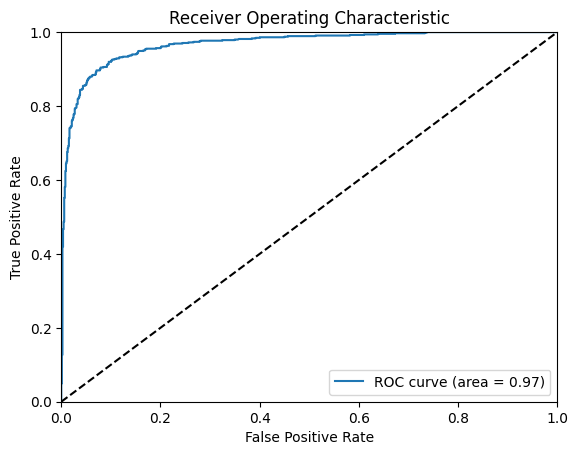

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize Logistic Regression Model
logreg = LogisticRegression(random_state=42)

# Fit the model
logreg.fit(x_train, y_train)

# Predictions
y_pred = logreg.predict(x_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Classification Report
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

# Confusion Matrix
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")

# Compute ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:, 1])
# AUC (Area Under Curve) score represents the ability of the model to distinguish between the positive and negative class: 
# 1 is perfect, 0.5 is random, and 0 is perfectly wrong.
area_under_curve_for_roc = auc(false_positive_rate, true_positive_rate)

# Plot ROC curve
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % area_under_curve_for_roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### 4.1.2. Support Vector Machines

Accuracy: 0.9143239625167336
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       847
           1       0.92      0.88      0.90       647

    accuracy                           0.91      1494
   macro avg       0.92      0.91      0.91      1494
weighted avg       0.91      0.91      0.91      1494

Confusion Matrix: 
 [[799  48]
 [ 80 567]]


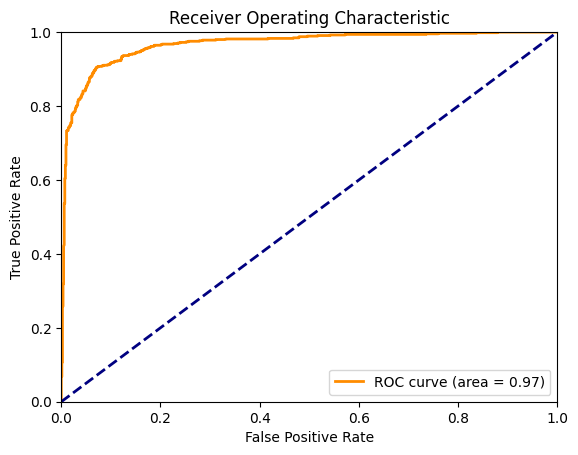

In [78]:
from sklearn.svm import SVC

# Initialize SVM model
svm_model = SVC(kernel='linear', C=1, random_state=42, probability=True)

# Fit the model
svm_model.fit(x_train, y_train)

# Predictions
y_pred = svm_model.predict(x_test)

# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")

# Predict probabilities
y_prob = svm_model.predict_proba(x_test)[:,1]

# Compute ROC curve and AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot ROC curve
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4.2. With hyperparameter tuning

#### 4.2.1. Logistic regression

In [79]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 2, 4, 6, 8, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on the test set
y_pred = grid_search.best_estimator_.predict(x_test)
print("Accuracy after GridSearchCV: ", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy after GridSearchCV:  0.9136546184738956


#### 4.2.2. Support Vector Machines

In [80]:
# Define hyperparameters and their possible values
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 2, 4, 6, 8, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=5, n_jobs=-1, verbose=1)

# Fit to the training data
grid_search_svm.fit(x_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search_svm.best_params_}")

# Evaluate on the test set
y_pred_svm = grid_search_svm.best_estimator_.predict(x_test)
print("Accuracy after GridSearchCV: ", accuracy_score(y_test, y_pred_svm))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy after GridSearchCV:  0.9163319946452476
